# Tech - carte

Faire une carte, c'est toujours compliqué. C'est simple jusqu'à ce qu'on s'aperçoive qu'on doit récupérer la description des zones administratives d'un pays, fournies parfois dans des coordonnées autres que longitude et latitude. Quelques modules utiles :

* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) : surcouche de matplotlib pour faire des dessins avec des coordonnées géographiques
* [bokeh](https://docs.bokeh.org/) : pour tracer des cartes interactives
* [pyproj](https://github.com/pyproj4/pyproj) : conversion entre systèmes de coordonnées
* [shapely](https://shapely.readthedocs.io/en/stable/manual.html) : manipuler des polygones géographiques (union, intersection, ...)
* [pyshp](https://github.com/GeospatialPython/pyshp) : lire ou écrire des polygones géographiques
* [geopandas](https://geopandas.org/) : manipulation de dataframe avec des coordonnées géographiques

Quelques notebooks intéressants :
* [Tracer une carte en Python avec bokeh](http://195-154-200-30.rev.poneytelecom.eu/app/papierstat/helpsphinx/notebooks/enedis_cartes_bokeh.html)
* [Tracer une carte en Python](http://195-154-200-30.rev.poneytelecom.eu/app/papierstat/helpsphinx/notebooks/enedis_cartes.html)
* [Données carroyées et OpenStreetMap](http://195-154-200-30.rev.poneytelecom.eu/app/papierstat/helpsphinx/notebooks/carte_carreau.html)
* [Carte de France avec les départements](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td1a_cenonce_session_12_carte.html)
* [Carte de France avec les départements (2)](http://www.xavierdupre.fr/app/actuariat_python/helpsphinx/notebooks/seance6_graphes_correction.html)

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Exposé

On télécharge des [données hospitalières par départements](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/).

### Données COVID

In [3]:
# https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/
from pandas import read_csv
url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
covid = read_csv(url, sep=";")
covid.tail()

,dep,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
301945,976,0,2022-12-02,8,0,8.0,0.0,0.0,1703,163
301946,976,1,2022-12-02,5,0,5.0,0.0,0.0,709,100
301947,976,2,2022-12-02,3,0,3.0,0.0,0.0,969,61
301948,978,0,2022-12-02,0,0,0.0,0.0,0.0,0,0
301949,978,1,2022-12-02,0,0,0.0,0.0,0.0,0,0


In [4]:
last_day = covid.loc[covid.index[-1], "jour"]
last_day

'2022-12-02'

In [5]:
last_data = covid[covid.jour == last_day].groupby("dep").sum(numeric_only=True)
last_data.shape

(102, 8)

In [6]:
last_data.describe()

,sexe,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,2.980392,386.686275,21.754902,231.264706,121.470588,12.196078,15482.431373,2534.039216
std,0.198030,413.069001,29.729619,238.054654,156.744397,17.687070,15273.986786,2444.945989
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,130.250000,4.000000,89.000000,24.000000,0.000000,5949.500000,932.000000
50%,3.000000,246.500000,12.000000,153.000000,73.500000,4.000000,10183.000000,1644.000000
75%,3.000000,448.000000,25.500000,277.250000,155.000000,18.000000,19457.000000,3084.000000
max,3.000000,2203.000000,162.000000,1430.000000,1055.000000,83.000000,88785.000000,12515.000000


In [7]:
last_data.head()

,sexe,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
dep,,,,,,,,
01,3,201,6,102.0,89.0,4.0,9021,1625
02,3,252,16,134.0,92.0,10.0,15490,3099
03,3,116,6,98.0,10.0,2.0,10824,1772
04,3,227,2,102.0,123.0,0.0,4820,748
05,3,98,0,24.0,74.0,0.0,5646,787


In [8]:
last_data.tail()

,sexe,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
dep,,,,,,,,
972,3,105,6,83.0,16.0,0.0,9000,2142
973,3,46,10,34.0,2.0,0.0,12343,802
974,3,200,8,47.0,145.0,0.0,16726,1882
976,3,16,0,16.0,0.0,0.0,3381,324
978,1,0,0,0.0,0.0,0.0,0,0


### Données départements

On récupère ensuite la définition [géographique des départements](https://www.data.gouv.fr/en/datasets/contours-geographiques-des-departements/).

In [9]:
import geopandas
# dernier lien de la page (format shapefiles)
url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"
geo = geopandas.read_file(url)
geo.tail()

,code,nom,geometry
91,91,Essonne,"POLYGON ((2.22656 48.77610, 2.22866 48.77451, ..."
92,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
93,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
94,94,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."
95,95,Val-d'Oise,"POLYGON ((2.59052 49.07965, 2.59013 49.07786, ..."


Il faudrait aussi fusionner avec la population de chaque département. Ce sera pour une autre fois. 

### Carte

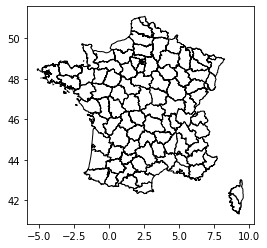

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
geo.plot(ax=ax, color='white', edgecolor='black');

On enlève tous les départements à trois chiffres. Les départements outre-mer sont présents ou non selon le jeu de données téléchargé.

In [11]:
codes = [_ for _ in set(geo.code) if len(_) < 3]
metropole = geo[geo.code.isin(codes)]
metropole.tail()

,code,nom,geometry
91,91,Essonne,"POLYGON ((2.22656 48.77610, 2.22866 48.77451, ..."
92,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
93,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
94,94,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."
95,95,Val-d'Oise,"POLYGON ((2.59052 49.07965, 2.59013 49.07786, ..."


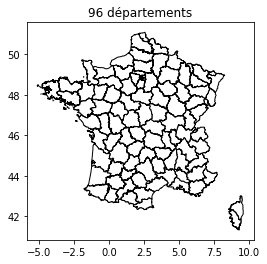

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
metropole.plot(ax=ax, color='white', edgecolor='black')
ax.set_title("%s départements" % metropole.shape[0]);

### Carte COVID

In [13]:
merged = last_data.reset_index(drop=False).merge(metropole, left_on="dep", right_on="code")
merged.shape

(96, 12)

In [14]:
merged.tail()

,dep,sexe,hosp,rea,HospConv,SSR_USLD,autres,rad,dc,code,nom,geometry
91,91,3,715,40,337.0,308.0,30.0,33284,5225,91,Essonne,"POLYGON ((2.22656 48.77610, 2.22866 48.77451, ..."
92,92,3,1509,123,730.0,603.0,53.0,47450,7156,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
93,93,3,1921,91,714.0,1055.0,61.0,40699,6297,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
94,94,3,1196,48,685.0,400.0,63.0,45694,7898,94,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."
95,95,3,726,18,440.0,252.0,16.0,31208,5478,95,Val-d'Oise,"POLYGON ((2.59052 49.07965, 2.59013 49.07786, ..."


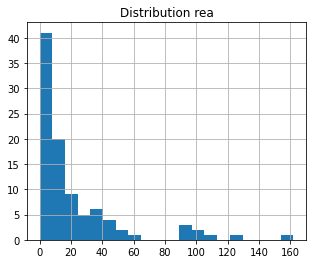

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
merged.hist('rea', bins=20, ax=ax)
ax.set_title("Distribution rea");

Les régions les plus peuplées ont sans doute la plus grande capacité hospitalière. Il faudrait diviser par cette capacité pour avoir une carte qui ait un peu plus de sens. Comme l'idée est ici de simplement tracer la carte, on ne calculera pas de ratio.

In [16]:
merged.sort_values('rea').tail()

,dep,sexe,hosp,rea,HospConv,SSR_USLD,autres,rad,dc,code,nom,geometry
12,13,3,1551,98,864.0,579.0,10.0,88785,11852,13,Bouches-du-Rhône,"MULTIPOLYGON (((5.39670 43.17300, 5.39314 43.1..."
33,33,3,970,102,702.0,152.0,14.0,27382,3831,33,Gironde,"MULTIPOLYGON (((-1.23902 44.59278, -1.23583 44..."
59,59,3,1723,110,1075.0,466.0,72.0,70645,11328,59,Nord,"MULTIPOLYGON (((3.04040 50.15971, 3.04599 50.1..."
92,92,3,1509,123,730.0,603.0,53.0,47450,7156,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
75,75,3,2203,162,1430.0,593.0,18.0,73440,12515,75,Paris,"POLYGON ((2.33190 48.81701, 2.33247 48.81825, ..."


In [17]:
geomerged = geopandas.GeoDataFrame(merged)

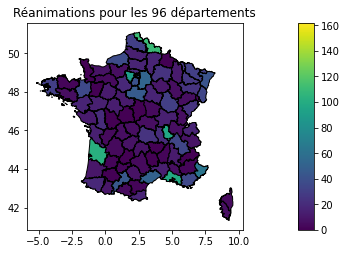

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

# ligne à ajouter pour avoir une légende ajustée à la taille du graphe
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

geomerged.plot(column="rea", ax=ax, edgecolor='black', legend=True, cax=cax)
ax.set_title("Réanimations pour les %d départements" % metropole.shape[0]);

La création de carte a toujours été plus ou moins compliqué. Les premiers notebooks que j'ai créés sur le sujet étaient beaucoup plus complexe. *geopandas* a simplifié les choses. Son développement a commencé entre [2013](https://github.com/geopandas/geopandas/graphs/contributors) et a bien évolué depuis. Et j'ai dû passer quelques heures à récupérer les contours des départements il y a cinq ans.

On peut également récupérer la capacité maximale de chaque département en regardant sur le passé.

In [19]:
capacite = covid.groupby(["jour", "dep"]).sum().groupby("dep").max()
capacite.head()

,sexe,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
dep,,,,,,,,
01,3,904,78,287.0,187.0,36.0,9021,1625
02,3,688,125,392.0,250.0,18.0,15490,3099
03,3,558,58,394.0,91.0,12.0,10824,1772
04,3,381,30,136.0,184.0,26.0,4820,748
05,3,380,50,134.0,178.0,20.0,5646,787


In [20]:
capa_merged = merged.merge(capacite, left_on="dep", right_on="dep")
capa_merged["occupation"] = capa_merged["rea_x"] / capa_merged["rea_y"]
capa_merged.head(n=2).T

,0,1
dep,01,02
sexe_x,3,3
hosp_x,201,252
rea_x,6,16
HospConv_x,102.0,134.0
SSR_USLD_x,89.0,92.0
autres_x,4.0,10.0
rad_x,9021,15490
dc_x,1625,3099
code,01,02


In [21]:
geocapa = geopandas.GeoDataFrame(capa_merged)

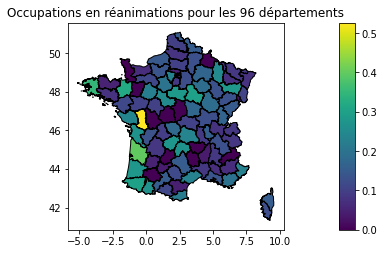

In [22]:
fig, ax = plt.subplots(1, 1)

# ligne à ajouter pour avoir une légende ajustée à la taille du graphe
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

geocapa.plot(column="occupation", ax=ax, edgecolor='black', legend=True, cax=cax)
ax.set_title("Occupations en réanimations pour les %d départements" % metropole.shape[0]);